#### Log - Regression

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from src.miss_glm import MissGLM, MissGLMSelector

# Set parameters
n = 200  # number of subjects
p = 5    # number of explanatory variables
mu_star = np.arange(0, p)/4  # mean of the explanatory variables
sd = np.arange(1, p+1)/3      # standard deviations
seed = 21

np.random.seed(seed)

# Correlation matrix
C = np.array([
    [1,   0.8, 0,   0,   0],
    [0.8, 1,   0,   0,   0],
    [0,   0,   1,   0.99, 0.6],
    [0,   0,   0.99, 1,   0.7],
    [0,   0,   0.6, 0.7, 1]
])

# Covariance matrix
Sigma_star = np.diag(sd) @ C @ np.diag(sd)

# Coefficients
beta_star = np.array([0.9, 0.11, -1.8, 0.3, -0.77])
beta0_star = -0.2  # intercept
# beta_star = np.random.randn(p)*1
# beta0_star = np.random.randn(1)*2
beta_true = np.hstack([beta0_star, beta_star])
print("True coefficients: ", beta_true)

# Design matrix
X_complete = np.random.randn(n, p) @ np.linalg.cholesky(Sigma_star).T + mu_star

# Response vector
p1 = 1 / (1 + np.exp(-(X_complete @ beta_star + beta0_star)))
y = (np.random.rand(n) < p1).astype(int)

# Plot Y vs X1, X2, X3, X4, X5
jitter = np.random.normal(0, 0.05, n)

# Set the proportion of missing values
p_miss = 0.20

# Generate missing values MCAR
X_miss = X_complete.copy()
X_miss[np.random.rand(*X_miss.shape) < p_miss] = np.nan

True coefficients:  [-0.2   0.9   0.11 -1.8   0.3  -0.77]


In [18]:

model = MissGLM(maxruns=500, tol_em=1e-7, var_cal=True, ll_obs_cal=False, seed=seed, k1=50, tau=1)

# Fit the model
model.fit(X_miss, y, save_trace=True)

  0%|          | 1/500 [00:00<00:55,  9.04it/s]

 80%|████████  | 400/500 [00:18<00:04, 21.11it/s]


MissGLM(ll_obs_cal=False, seed=21, subsets=array([0, 1, 2, 3, 4]), tau=1)

In [19]:
model.ll_obs

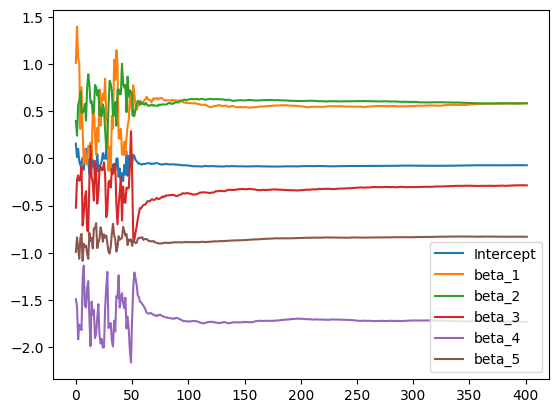

In [20]:
b = np.array(model.trace["beta"])
plt.figure()

plt.plot(b[:, 0], label="Intercept")
for i in range(p):
    plt.plot(b[:, i+1], label=f"beta_{i+1}")
plt.legend()
plt.show()

In [21]:
n_preds = 300
np.random.seed(11)
newX = np.random.randn(n_preds, p) @ np.linalg.cholesky(Sigma_star).T + mu_star
newX_miss = newX.copy()
newX_miss[np.random.rand(*newX.shape) < p_miss] = np.nan

preds = model.predict_proba(newX_miss, method="impute")[:,1]

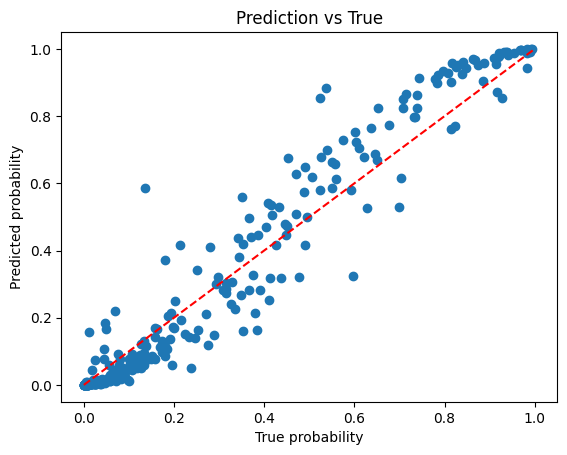

R²:  0.9250356861783103


In [22]:
# plot prediction vs true

true_prob = 1 / (1 + np.exp(-(newX @ beta_star + beta0_star)))

plt.figure()
plt.plot(true_prob, preds, 'o')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("True probability")
plt.ylabel("Predicted probability")
plt.title("Prediction vs True")
plt.show()


# compute R²

R2 = 1 - np.sum((true_prob - preds)**2) / np.sum((true_prob - np.mean(true_prob))**2)
print("R²: ", R2)

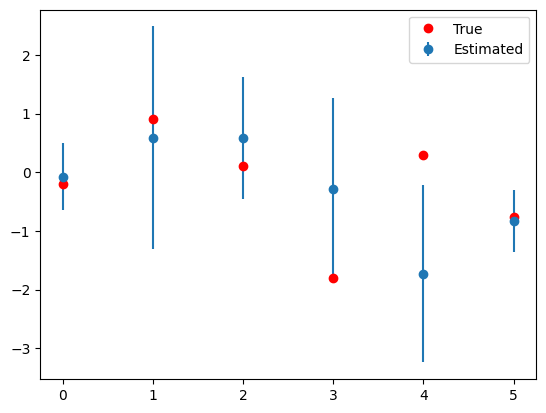

In [23]:
# plot C.I of coefficients
# with real coef in red

plt.errorbar(np.arange(p+1), model.coef_, yerr=model.std_err * 1.96, fmt='o', label='Estimated')
plt.plot(np.arange(p+1), beta_true, 'ro', label='True')
plt.legend()
plt.show()


#### Model Selection

In [24]:
X_null = np.random.randn(n, 1)

# concat above X complete and X_null
X_complete_null = np.hstack([X_complete, X_null])

# missing MCAR
patterns = np.random.rand(n, X_complete_null.shape[1]) < p_miss
X_complete_null[patterns] = np.nan

In [25]:
model_selection = MissGLMSelector()
best_model = model_selection.fit(X_complete_null, y, progress_bar=True)

100%|██████████| 21/21 [02:53<00:00,  8.27s/it]


In [26]:
model_selection.get_support(indices=False)

array([False, False, False,  True,  True, False])

In [27]:
best_model.coef_

array([-0.07503375, -1.62125659, -0.64071355])

In [28]:
full_model = MissGLM(maxruns=500, tol_em=1e-7, var_cal=True, ll_obs_cal=False, seed=seed, k1=50, tau=1)
full_model.fit(X_complete_null, y, save_trace=True)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:18<00:00, 27.04it/s]


MissGLM(ll_obs_cal=False, seed=21, subsets=array([0, 1, 2, 3, 4, 5]), tau=1)

In [29]:
full_model.coef_

array([-0.28678805,  0.79737192,  0.66633719, -0.80283214, -1.27055028,
       -0.71569962, -0.37190539])

In [30]:
np.array(list(beta_true) + [0])

array([-0.2 ,  0.9 ,  0.11, -1.8 ,  0.3 , -0.77,  0.  ])